In [14]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [15]:
median_width = 549 	 
median_height = 590
image_size = (median_width, median_height)

In [16]:
def build_model(median_width, median_height):
    model = keras.Sequential([
        layers.InputLayer(shape=(median_width, median_height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    return model

In [17]:
def plot_info(axes, type):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic")

In [5]:
def load_subdataset(base_dir, subdataset, painters, width, height):
    train_datagen = ImageDataGenerator(rescale=1./255) #Uitzoeken
    train_generator = train_datagen.flow_from_directory(
        f'{base_dir}/{subdataset}',
        target_size=(width, height),
        batch_size=16,
        class_mode='binary', 
        classes=painters,
    )    
    return train_generator


def load_dataset(base_dir, painters, width, height):
    train_generator = load_subdataset(base_dir, "train", painters, width, height)
    validation_generator = load_subdataset(base_dir, "validation", painters, width, height)
    test_generator = load_subdataset(base_dir, "test", painters, width, height)
    return train_generator, validation_generator, test_generator

In [18]:
def load_dataset(base_dir, painters, width, height, batch_size=16):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
    )
    return train_dataset, validation_dataset, test_dataset

## Undersampled dataset:

### Data inladen:

In [20]:
painters = ["Mondriaan", "Picasso"]
train, val, test = load_dataset("undersampled_dataset", painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


### Model trainen

In [21]:
model = build_model(median_width, median_height)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 549, 590, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 547, 588, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 273, 294, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 271, 292, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 135, 146, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 133, 144, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 66, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 70, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 35, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 33, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        61,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,039,937 (3.97 MB)

 Trainable params: 1,039,937 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.4250 - loss: 2235640320.0000 - val_accuracy: 0.5882 - val_loss: 72.9398
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5581 - loss: 121.8409 - val_accuracy: 0.5000 - val_loss: 245.2296
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6280 - loss: 71.8554 - val_accuracy: 0.4706 - val_loss: 30.6720
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5999 - loss: 23.2252 - val_accuracy: 0.5980 - val_loss: 22.4506
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.6448 - loss: 10.0037 - val_accuracy: 0.5294 - val_loss: 10.7770
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.6515 - loss: 2.0137 - val_accuracy: 0.4902 - val_loss: 10.9690
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5782 - loss: 2.4302 - val_accuracy: 0.5098 - val_loss: 3.3794
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5657 - loss: 0.96

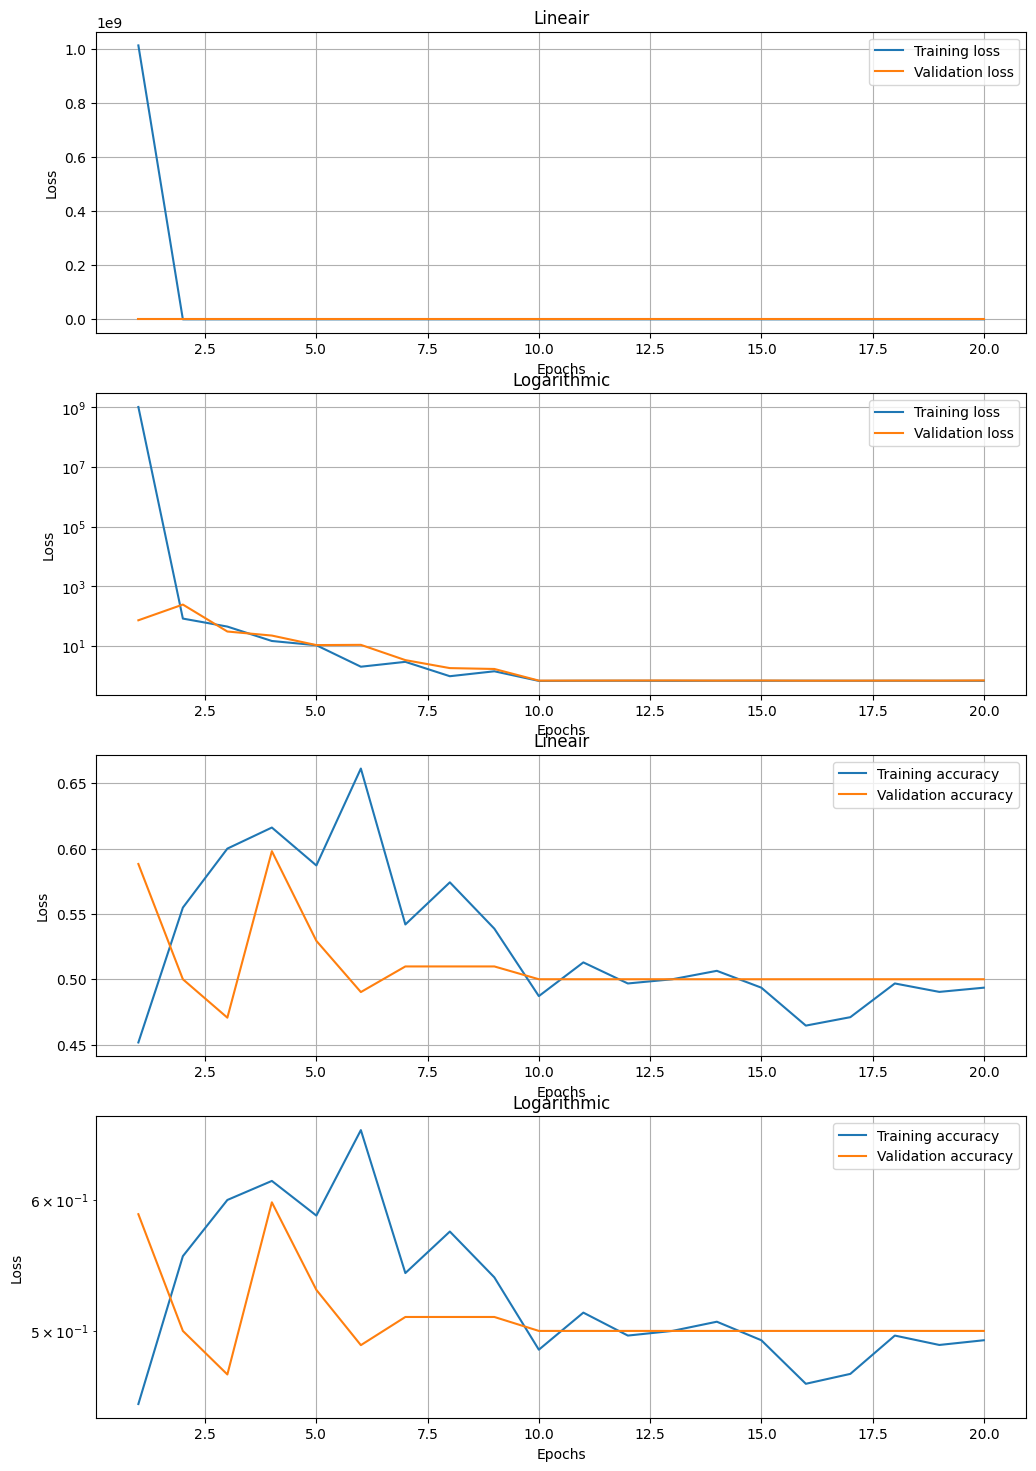

In [23]:
plot_loss(history)

In [30]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.50      1.00      0.67        51

    accuracy                           0.50       102
   macro avg       0.25      0.50      0.33       102
weighted avg       0.25      0.50      0.33       102



2024-12-23 08:36:26.478140: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Oversampled dataset

### loading data

In [32]:
train, val, test = load_dataset("oversampled_dataset", painters, median_height, median_width)
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - accuracy: 0.5565 - loss: 1.7638 - val_accuracy: 0.6590 - val_loss: 0.6457
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.6587 - loss: 0.7096 - val_accuracy: 0.5984 - val_loss: 0.7048
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.7432 - loss: 0.5308 - val_accuracy: 0.8311 - val_loss: 0.4105
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.8680 - loss: 0.3409 - val_accuracy: 0.9082 - val_loss: 0.2854
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9229 - loss: 0.1836 - val_accuracy: 0.9033 - val_loss: 0.3255
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9457 - loss: 0.1810 - val_accuracy: 0.9410 - val_loss: 0.2090
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.9667 - loss: 0.0987 - va

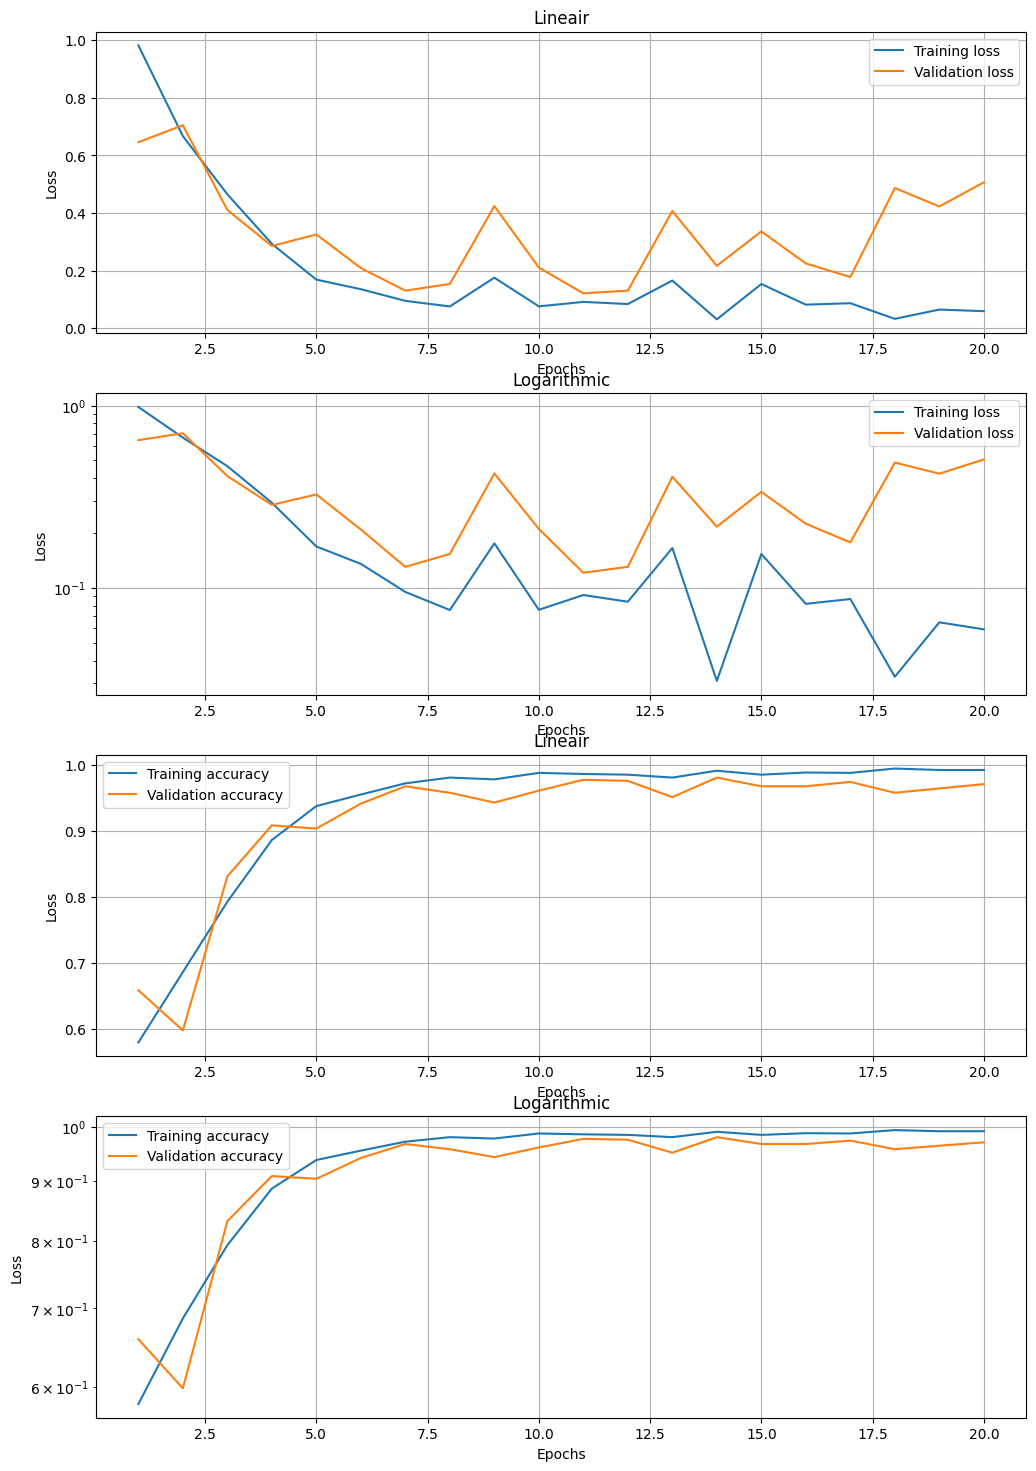

In [33]:
plot_loss(history)

In [18]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 546ms/step
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       305
           1       0.50      0.48      0.49       305

    accuracy                           0.50       610
   macro avg       0.50      0.50      0.50       610
weighted avg       0.50      0.50      0.50       610



## imbalanced dataset

### loading dataset

In [42]:
train, val, test = load_dataset("imbalanced_dataset", painters, median_width, median_height, batch_size=8)

Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


### Fitting model 

Mondriaan = 0, Picasso = 1

In [43]:
train.class_names

['Mondriaan', 'Picasso']

In [44]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

2024-12-23 08:52:54.586857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(1115, {np.int32(1): 917, np.int32(0): 198})

In [45]:
mondriaan_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight


{0: 2.8156565656565657, 1: 0.6079607415485279}

In [48]:
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

Epoch 1/20


2024-12-23 08:54:31.763468: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31095840 bytes after encountering the first element of size 31095840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5504 - loss: 0.7065 - val_accuracy: 0.1769 - val_loss: 0.7768
Epoch 2/20
  1/140 ━━━━━━━━━━━━━━━━━━━━ 55s 399ms/step - accuracy: 0.0000e+00 - loss: 0.5084

2024-12-23 08:54:48.983316: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31095840 bytes after encountering the first element of size 31095840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.4825 - loss: 0.6845 - val_accuracy: 0.7158 - val_loss: 0.6531
Epoch 3/20
  3/140 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7500 - loss: 0.6251 

2024-12-23 08:54:59.613812: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31095840 bytes after encountering the first element of size 31095840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6461 - loss: 0.6729 - val_accuracy: 0.6139 - val_loss: 0.6418
Epoch 4/20
  2/140 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5625 - loss: 0.5464  

2024-12-23 08:55:09.416124: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31095840 bytes after encountering the first element of size 31095840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6589 - loss: 0.6605 - val_accuracy: 0.8231 - val_loss: 0.5849
Epoch 5/20
  1/140 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.8750 - loss: 0.7179

2024-12-23 08:55:19.043723: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31095840 bytes after encountering the first element of size 31095840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.7198 - loss: 0.8469 - val_accuracy: 0.2922 - val_loss: 0.6960
Epoch 6/20


2024-12-23 08:55:39.754407: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31095840 bytes after encountering the first element of size 31095840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/140 ━━━━━━━━━━━━━━━━━━━━ 59s 415ms/step - accuracy: 0.4537 - loss: 0.6742 - val_accuracy: 0.2038 - val_loss: 0.8833
Epoch 7/20


2024-12-23 08:56:38.483885: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31095840 bytes after encountering the first element of size 31095840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  3/140 ━━━━━━━━━━━━━━━━━━━━ 1:17 569ms/step - accuracy: 0.3056 - loss: 0.8414

2024-12-23 08:56:47.074401: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 4294967296 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1734940607.079428   17031 device_host_allocator.h:61] could not allocate pinned host memory of size: 4294967296
2024-12-23 08:56:47.080845: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 3865470464 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1734940607.080861   17031 device_host_allocator.h:61] could not allocate pinned host memory of size: 3865470464
2024-12-23 08:56:47.080868: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 3478923264 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1734940607.080870   17031 device_host_allocator.h:61] could not allocate pinned host memory of size: 3478923264


: 

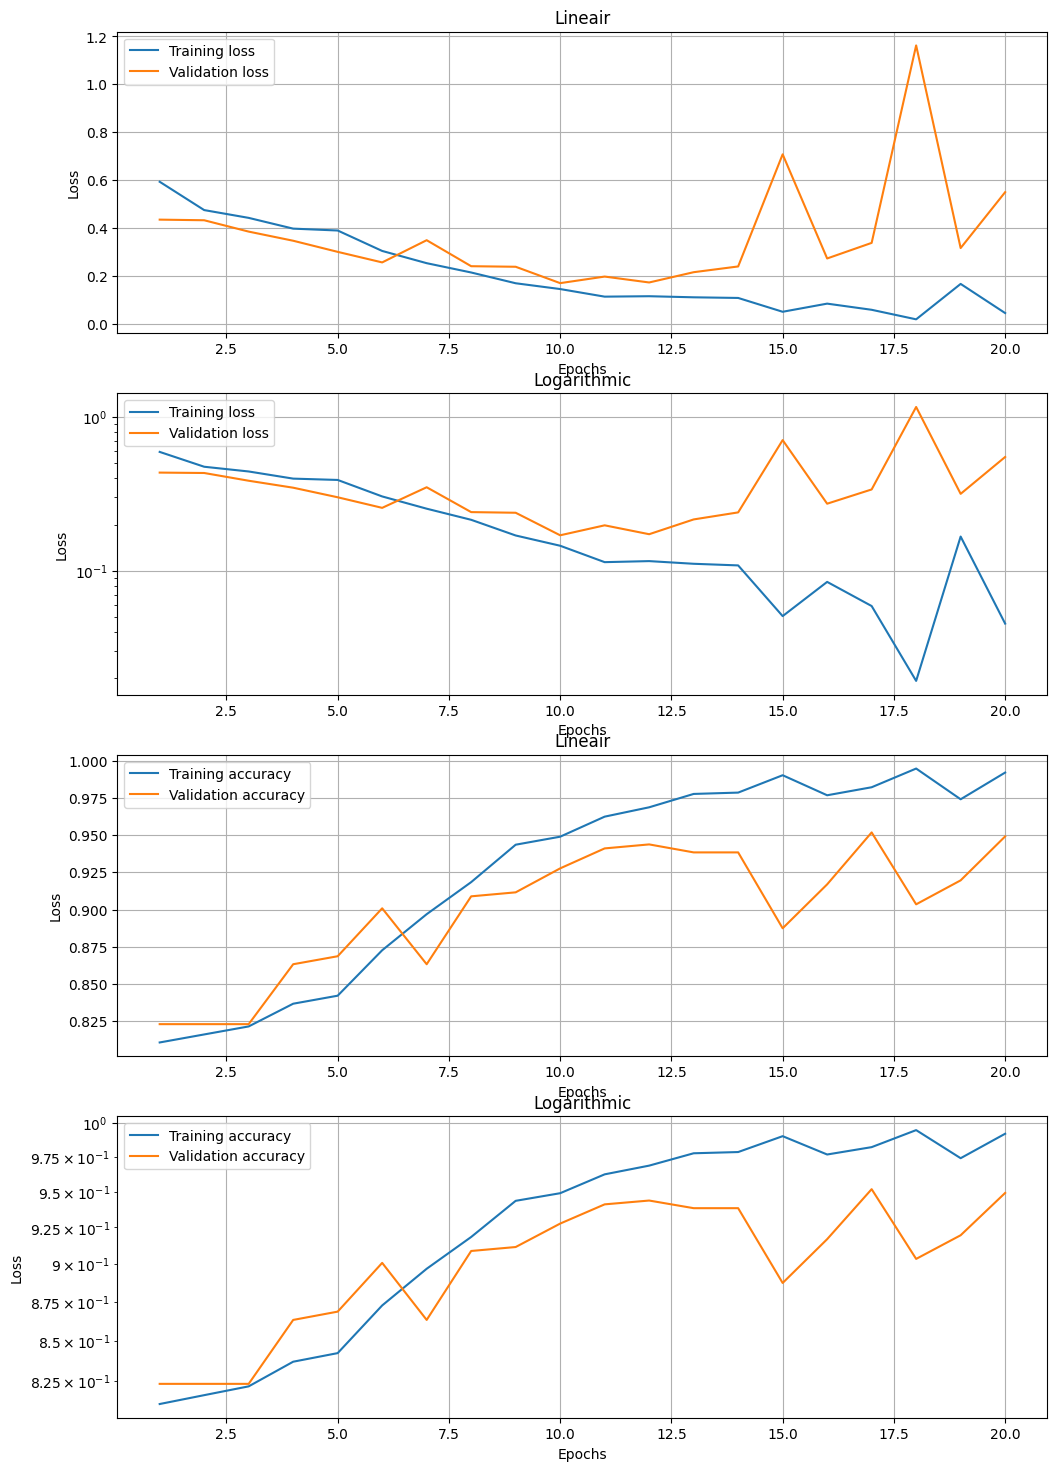

In [ ]:
plot_loss(history)

In [45]:
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred)
y_true = test_generator.classes
print(classification_report(y_true, y_pred))

/home/timmo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 542ms/step
              precision    recall  f1-score   support

           0       0.18      0.18      0.18        66
           1       0.82      0.82      0.82       305

    accuracy                           0.70       371
   macro avg       0.50      0.50      0.50       371
weighted avg       0.71      0.70      0.71       371



Image size bepalen

minimum

In [55]:
min_width = 106 	 
min_height = 115
image_size = (min_width, min_height)

In [56]:
train_generator, val_generator, test_generator = load_dataset("imbalanced_dataset", painters, min_width, min_height)
images, labels = next(train_generator)
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"Single image shape: {images[0].shape}")

Found 1115 images belonging to 2 classes.
Found 373 images belonging to 2 classes.
Found 371 images belonging to 2 classes.
Image batch shape: (16, 106, 115, 3)
Label batch shape: (16,)
Single image shape: (106, 115, 3)


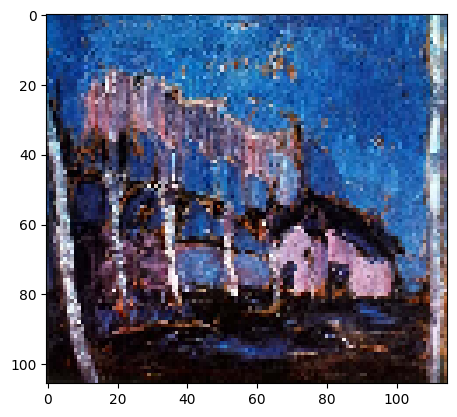

In [58]:
plt.imshow(images[0])

In [ ]:
model = build_model(min_width, min_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_generator, epochs=20, validation_data=val_generator)